# Анализ А/B теста интернет-магазина и приоритизация гипотез
Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.


*   Приоритизируем гипотезы
*   Запустим A/B-тест и проанализируйте результаты


## Предобработка данных

In [1]:
# Импортируем все необходимые библиотеки:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams ['figure.figsize'] = [15, 10]
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузим файлы на gdrive, для удобства работы через Colab..
# Путь к таблицам на gdrive
# hypothesis
# https://drive.google.com/file/d/1yT04ixmr4HWC8W-EPE81xvoMl052oCAe/view?usp=share_link
# orders
# https://drive.google.com/file/d/1kEsl4jQOHNUxANcNhuGMs2K3JkXXgYW2/view?usp=share_link
# visitors
# https://drive.google.com/file/d/1T0fPf2diielQ2imZxMOFBMlCIZd1wJX2/view?usp=share_link

In [3]:
# Сделаем универсальную загрузку чтобы работать через Colab и JupiterNotebook:

try:
    hypothesis, orders, visitors = (
        pd.read_csv('/content/hypothesis.csv'),
        pd.read_csv('/content/orders.csv'),
        pd.read_csv('/content/visitors.csv')
    )
except:
    hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),
        pd.read_csv('/datasets/orders.csv'),
        pd.read_csv('/datasets/visitors.csv')
    )
pd.options.display.max_colwidth = 150
hypothesis.info()
hypothesis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
orders.info()
orders

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [5]:
visitors.info()
visitors

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [6]:
# так же оценим наличие полных дубликатов в таблицах orders и visitors
print(f'Количество дубликатов:{orders.duplicated().sum()}')
print(f'Количество дубликатов:{visitors.duplicated().sum()}')

Количество дубликатов:0
Количество дубликатов:0


На первый взгляд мы видим что данные датасеты прошли предобработку и не содержат дубликатов, однако некоторые типы данных не соответствуют ожидаемым(столбцы с датами имеют тип object), а так же некоторые столбцы содержат заглавные буквы в наименовании

In [7]:
# приведем тип данных к date
visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

In [8]:
# приведем к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = orders.columns.str.lower()
display(hypothesis.columns)
orders.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Index(['transactionid', 'visitorid', 'date', 'revenue', 'group'], dtype='object')

## Часть 1. Приоритизация гипотез.
У нас есть датасет с девятью гипотезами по увеличению выручки интернет-магазина
 - Hypothesis — краткое описание гипотезы;
 - Reach — охват пользователей по 10-балльной шкале;
 - Impact — влияние на пользователей по 10-балльной шкале;
 - Confidence — уверенность в гипотезе по 10-балльной шкале;
 - Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Применим фреймворк ICE для приоритизации гипотез. ICE (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота») — один из самых популярных способов приоритизации задач. Отсортируем их по убыванию приоритета.

In [9]:
hypothesis['ICE'] = (hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']  
hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Видим что гипотезы под номерами 8,0,7,6,2 имеют наибольший приоретет. Посмотрим на приоритизацию гипотез с помощью модификации RICE, учитывющую охват пользователей 

Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [10]:
hypothesis['RICE'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Видим что гипотезы под номерами 7,2,0,6,8 имеют наибольший приоретет. По сути это те же гипотезы, что и по методу ICE только в другом порядке, т.к метод RICE учитывает охват пользователей которых затронут изменения

## Часть 2. Анализ A/B-теста
1. Построим график кумулятивной выручки по группам.

In [11]:
ab_visitors = []
for x in orders[orders['group']=='A']['visitorid'].unique():
    if x in orders[orders['group']=='B']['visitorid'].unique():ab_visitors.append(x)
print('Пользователи в обеих группах:', ab_visitors)

Пользователи в обеих группах: [4069496402, 199603092, 3803269165, 2378935119, 237748145, 4256040402, 2038680547, 1738359350, 2458001652, 3891541246, 2716752286, 3656415546, 2686716486, 2954449915, 2927087541, 3234906277, 457167155, 2579882178, 3957174400, 1648269707, 2780786433, 818047933, 2044997962, 1959144690, 3202540741, 1333886533, 351125977, 3951559397, 393266494, 3984495233, 4120364173, 4266935830, 1230306981, 1294878855, 1614305549, 8300375, 477780734, 1668030113, 3717692402, 3766097110, 3941795274, 471551937, 1316129916, 1801183820, 1602967004, 2587333274, 2600415354, 232979603, 3972127743, 1404934699, 276558944, 3062433592, 2654030115, 3963646447, 4186807279, 2712142231, 2949041841, 963407295]


In [12]:
# для корректности дальнейшего анализа удалим пользователей которые находятся в двух группах теста одновременно
orders = orders.query('visitorid not in @ab_visitors')

In [13]:
datesGroups = orders[['date','group']].drop_duplicates() 
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
    'date' : 'max',
    'group' : 'max',
    'transactionid' : pd.Series.nunique,
    'visitorid' : pd.Series.nunique,
    'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
        'date' : 'max',
        'group' : 'max',
        'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head(10)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845
5,2019-08-03,B,54,53,288850,1803
6,2019-08-04,A,77,71,388030,2562
7,2019-08-04,B,68,66,385740,2573
8,2019-08-05,A,99,92,474413,3318
9,2019-08-05,B,89,87,475648,3280


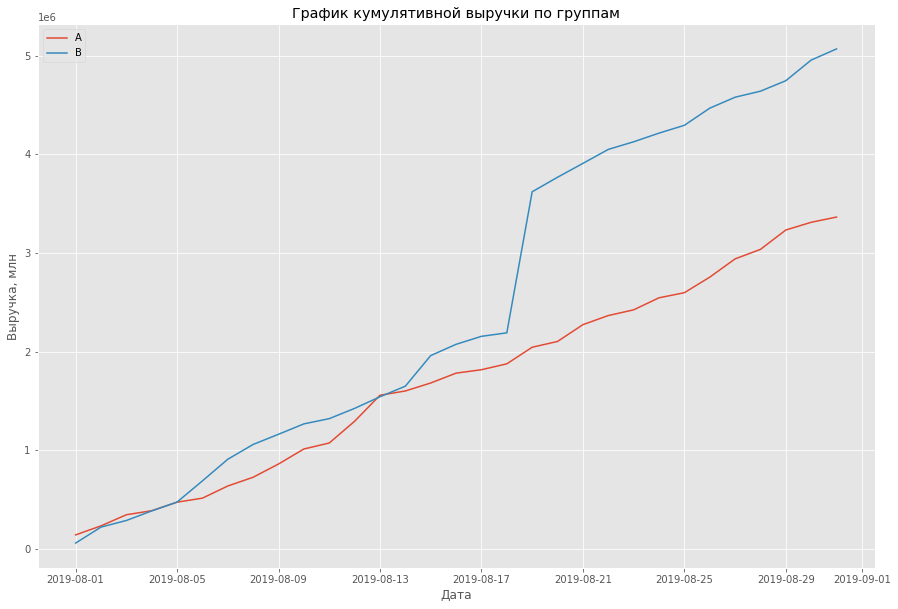

In [14]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A');

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B');

plt.title('График кумулятивной выручки по группам')
plt.ylabel("Выручка, млн")
plt.xlabel("Дата")
plt.legend() 
plt.show()


Видим что кумулятивная выручка группы B больше чем у группы А а так же что график выручки группы В резко растет в одной точке. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. Такие выбросы нам нужно будет убрать в дальнейшем..

2. Постройте график кумулятивного среднего чека по группам.

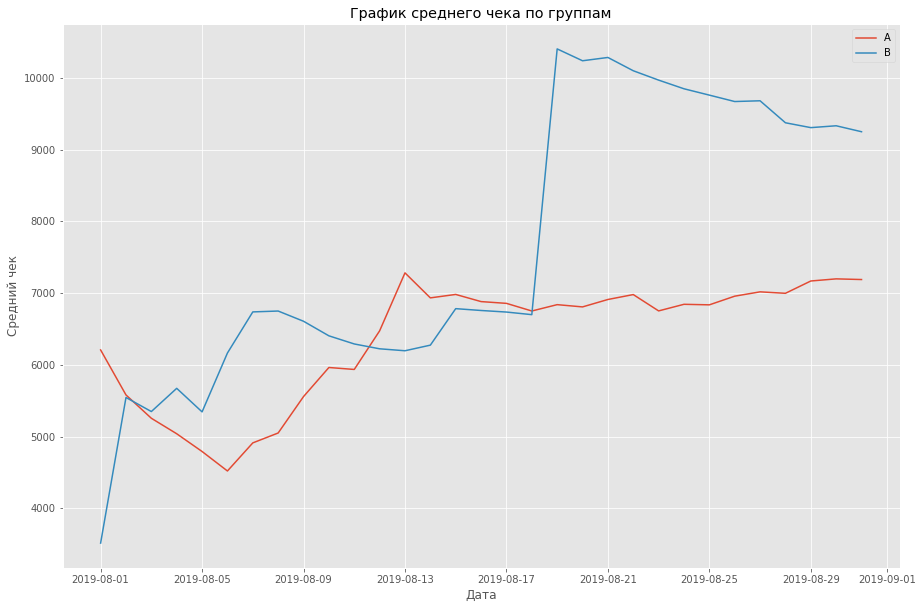

In [15]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График среднего чека по группам')
plt.ylabel('Средний чек')
plt.xlabel("Дата")
plt.legend() 
plt.show()

График среднего чека по группе А стабилизировался а график среднего чека по группе B показал резкий рывок в районе 18 августа, что говорит о резком росте среднего чека в этот день и соответственно аномально дорогих покупках.. 

 3. Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

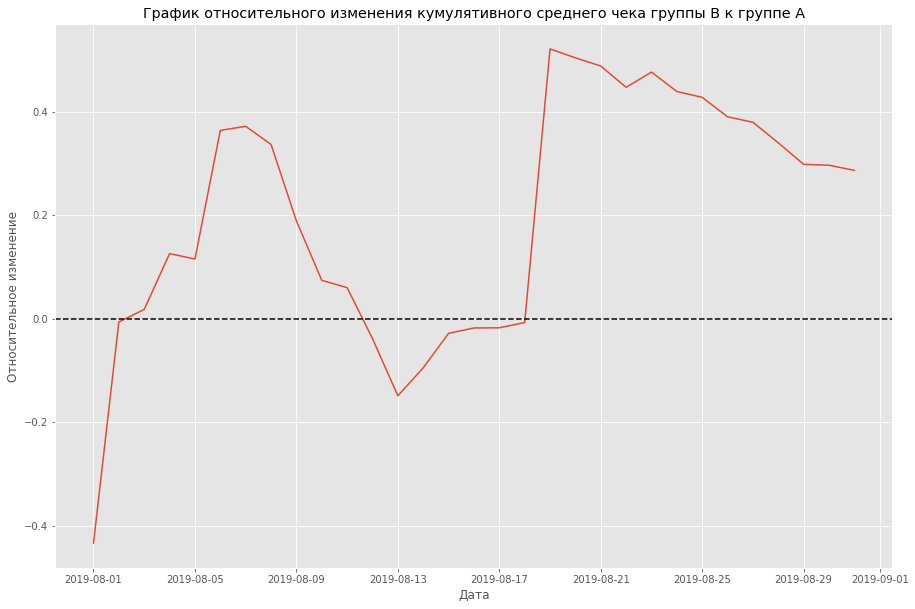

In [16]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel("Дата")
plt.ylabel('Относительное изменение')
plt.show()

График относительного изменения кумулятивного среднего чека сильно колеблется из стороны в сторону из за аномально "дорогих" заказов, наличие аномально дорогого заказа от 18.09 мы выявили ранее..

4. Построим график кумулятивного среднего количества заказов на посетителя по группам.

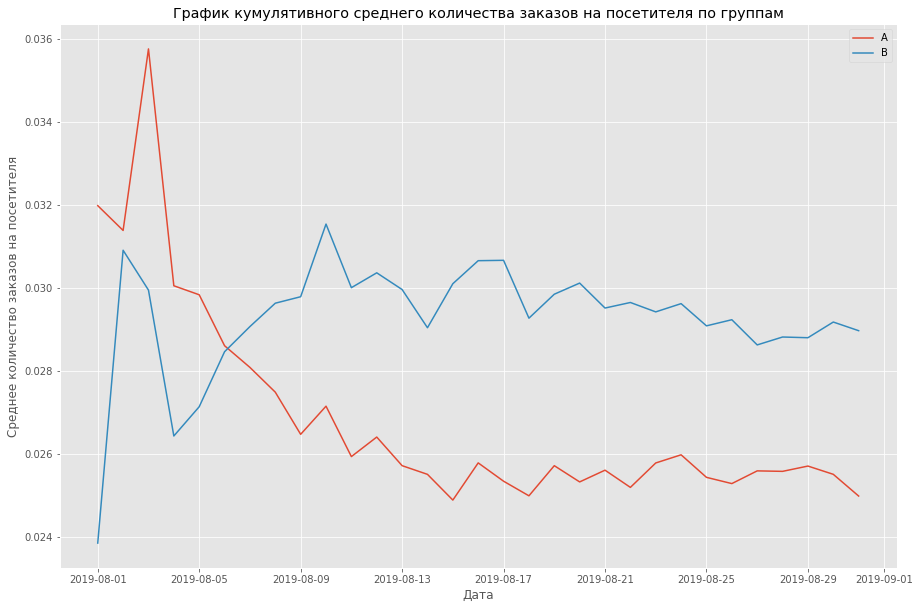

In [17]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xlabel("Дата")
plt.ylabel('Среднее количество заказов на посетителя')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам');

Сперва графики колебались но после стабилизировались, как видим у Группы В результат существенно лучше

5. Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

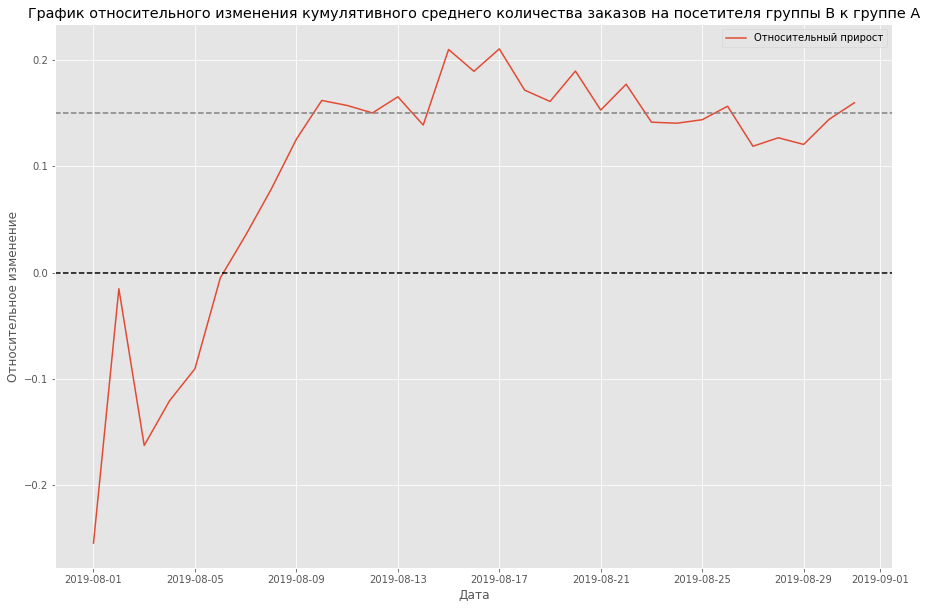

In [18]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост")
plt.legend()
plt.xlabel("Дата");
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.ylabel('Относительное изменение')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--');

Почти с самого начала группа В лидирует по конверсии, в настоящий момент она примерно на 15% лучше чем у группа А и возможно еще вырастет..

6. Построим точечный график количества заказов по пользователям.

         userId  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


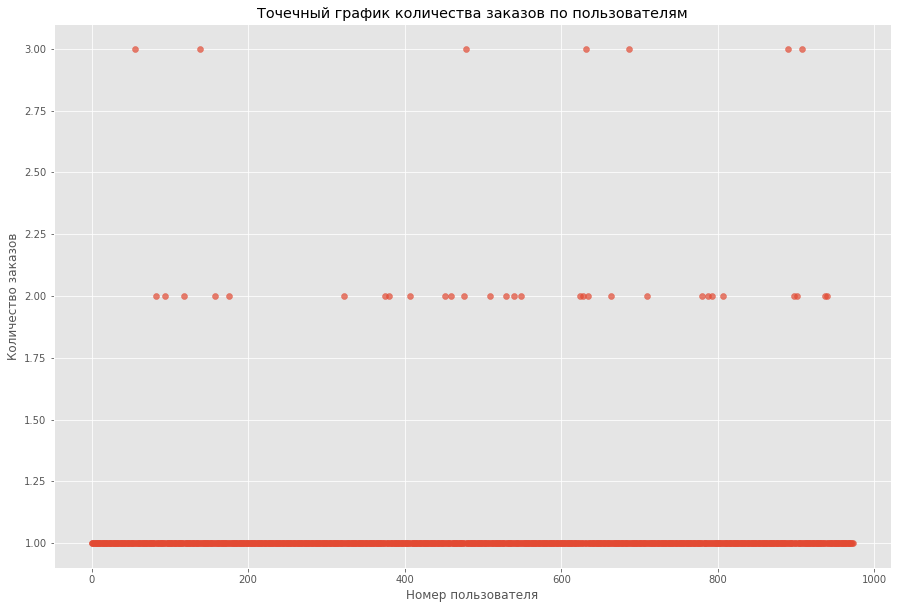

In [19]:
ordersByUsers = (
    orders.groupby('visitorid', as_index=False)
    .agg({'transactionid': 'nunique'})
)
ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Номер пользователя')
plt.ylabel('Количество заказов')
plt.scatter(x_values, ordersByUsers['orders'], alpha=0.7);


Как видим из графика у основной массы пользователей по одному заказу, есть пользователи заказавшие и 2 и 3 раза, однако их количество невелико, постараемся оценить их количество считая перцентили

7. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [20]:
np.percentile(ordersByUsers['orders'], [95,99])  # Метод np.percentile('column', [percentile1, percentile2]) находит перцентили.

array([1., 2.])

Не более 5 % пользователей совершили больше 1 заказа, не более 1 % совершили больше 2 заказов.. Примем за аномальных пользователей тех, кто совершил от 2 заказов. Так мы уберём 1% пользователей с наибольшим числом заказов

8. Построим точечный график стоимостей заказов.

      transactionid   visitorid       date  revenue group
425       590470918  1920142716 2019-08-19  1294500     B
1196     3936777065  2108080724 2019-08-15   202740     B
1136      666610489  1307669133 2019-08-13    92550     A
744      3668308183   888512513 2019-08-27    86620     B
743      3603576309  4133034833 2019-08-09    67990     A
1103     1348774318  1164614297 2019-08-12    66350     A
1099      316924019   148427295 2019-08-12    65710     A
949      1347999392   887908475 2019-08-21    60450     A
940      2420050534  4003628586 2019-08-08    58550     B
131      3163614039  2254586615 2019-08-22    53904     A


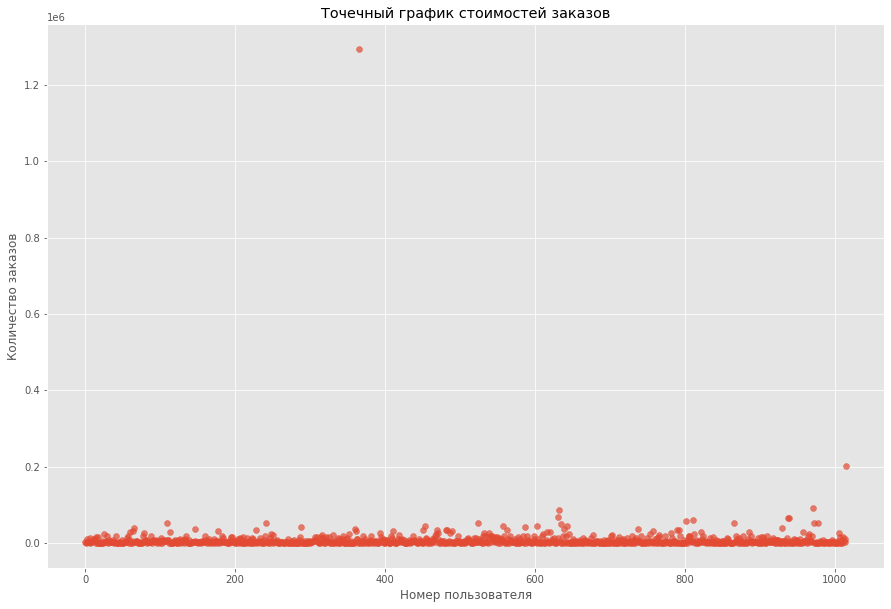

In [21]:
print(orders.sort_values(by='revenue', ascending=False).head(10))

x_values = pd.Series(range(0, len(orders['revenue'])))
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Номер пользователя')
plt.ylabel('Количество заказов')
plt.scatter(x_values, orders['revenue'],alpha=0.7);

In [22]:
display(orders['revenue'].describe())

count    1.016000e+03
mean     8.300815e+03
std      4.212199e+04
min      5.000000e+01
25%      1.190000e+03
50%      2.955000e+03
75%      8.134250e+03
max      1.294500e+06
Name: revenue, dtype: float64

В глаза сразу бросается аномально дорогой заказ (1.294 млн) о существовании которого мы  узнали ранее, так же видим что есть и другие крупные заказы..

9. Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [23]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

Примем за аномальных пользователей тех, кто совершил заказ дороже 53904 рублей. Так мы уберём 1% пользователей с самыми дорогими заказами. 

Ранее мы оценили результаты A/B-теста визуально и выяснили, что в данных, скорее всего, есть выбросы;
Увидели выбросы и нашли границу для их определения.

10. Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным без удаления аномальных пользователей.
Сформулируем гипотезы. 

*   Нулевая: различий в среднем количестве заказов между группами нет.
*   Альтернативная: различия в среднем между группами есть.

Для проверки гипотез будем использовать непараметрический тест Уилкоксона-Манна-Уитни. Он используется когда в данных есть большие (по сравнению с нормальным распределением) выбросы и это как раз наш случай

Начнём с подготовки данных.





In [24]:

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Напомним названия столбцов данных:
- date — дата;
- ordersPerDateA — количество заказов в выбранную дату в группе A;
- revenuePerDateA — суммарная выручка в выбранную дату в группе A;
- ordersPerDateB — количество заказов в выбранную дату в группе B;
- revenuePerDateB — суммарная выручка в выбранную дату в группе B;
- ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
- revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
- ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
- revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
- visitorsPerDateA — количество пользователей в выбранную дату в группе A;
- visitorsPerDateB — количество пользователей в выбранную дату в группе B;
- visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
- visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

Посчитаем статистическую значимость различия в среднем количестве заказов между группами.
 В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 

In [25]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorid', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorid', 'orders'] 

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [26]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

P-value возьмем равным 0.05

In [27]:
print("P-value: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("Относительный прирост В к А: {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

P-value: 0.011
Относительный прирост В к А: 0.160


Вывод: По «сырым» данным есть различия в среднем числе заказов групп A и B. 
Первое число — p-value = 0.011 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов на посетителя между группами нет,  отвергаем. Однако относительный выигрыш группы B равен 16.0% — второе число в выводе.

11. Теперь проверим статистическую значимость различий в среднем чеке между сегментами по «сырым» данным

*   Нулевая гипотеза: различий в среднем чеке между группами нет.
*   Альтернативная гипотеза: различия в среднем чеке между группами есть. 

P-value возьмем равным 0.05



In [28]:
print('P-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительный прирост В к А: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

P-value: 0.829
Относительный прирост В к А: 0.287


Первое число — p-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно больше среднего чека группы A.

12. Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Напомним что мы решили принять за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 53904 рублей. Т.е убираем 1% таких пользователей. Сделаем срезы пользователей 


In [29]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'], 99)]['visitorid'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'], 99)]['visitorid'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], 99)]['visitorid']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormalUsers.head(5)


1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
Name: visitorid, dtype: int64

In [30]:
abnormalUsers.shape[0]  

16

Всего 16 аномальных пользователей.

In [31]:
(abnormalUsers.count() / orders['visitorid'].nunique())*100

1.644398766700925

Потери и в относительном выражении после фильтрации 1,6% 

Всего 16 аномальных пользователей. 

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [32]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorid'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorid'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Применим статистический критерий Манна-Уитни к полученным выборкам:

P-value возьмем равным 0.05

In [33]:
print('P-value: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост В к А: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

P-value: 0.007
Относительный прирост В к А: 0.189


Вывод: По «очищенным» данным так же есть различия в среднем числе заказов групп A и B. Первое число — p-value = 0.007 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов на посетителя между группами нет, отвергаем. Сегмент В лучше Сегмента А. Относительный выигрыш группы B равен 18.9% — второе число в выводе. 

13. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

P-value возьмем равным 0.05

In [34]:
print('P-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print("Относительный прирост В к А:  {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

P-value: 0.788
Относительный прирост В к А:  -0.032


Первое число — p-value  0.788 так же значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Обратим внимаение что после очистки данных средний чек группы B стал незначительно меньше среднего чека группы A.

# Выводы

В Части 1. Приоритизация гипотез нам удалось выявить следующие гипотезы требующие проработки отделом Маркетинга в первую очередь:
*  Запустить акцию, дающую скидку на товар в день рождения,
*  Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
*  Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
*   Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

Если учитывать охват пользователей то в первую очередь стоит обратить внимание на сл. гипотезы:

* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
*	Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	
*	Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	
*	Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

В Части 2. Анализ A/B-теста, нам удалось сделать сл. выводы:

По результатам проведенного A/B-теста мы выяснили, что группа B оказалась победителем. Cреднее количество заказов на посетителя между группами B и чем в группой А было выше примерно на 16-19% в пользу группы В. Это означает, что мы можем с большой уверенностью утверждать, что изменения, внесенные в группу B, оказали положительное влияние.  Хотя аномальные пользователи существенно повлияли на средний чек,cтатистически значимого различия по среднему чеку между группами не наблюдается ни по "сырым" ни по "очищенным" данным. Тенденции к улучшению результатов по группе А нет и соответственно мы можем остановить тест, зафиксировать победу группы В.

Таким образом, мы рекомендуем использовать изменения, внесенные в группу В, в качестве основы для дальнейшего развития интернет-магазина. Однако, мы также рекомендуем провести дополнительные тесты, чтобы убедиться в стабильности результатов и возможности их повторения в будущем.






